<a href="https://colab.research.google.com/github/Pointbreak82/Cosmic-SOS/blob/main/spacetitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [84]:
train_df = pd.read_csv('train.csv')
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (8693, 14)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: >

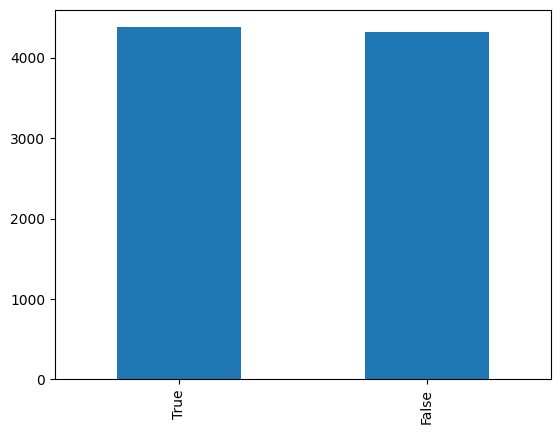

In [85]:
# Display the first 5 examples
train_df.head(5)

# Perform basic exploration of the dataset
train_df.describe()
train_df.info()

# Create a bar chart for the label column 'Transported'
plot_df = train_df['Transported'].value_counts()
plot_df.plot(kind="bar")

In [86]:
# Drop unnecessary columns
train_df = train_df.drop(['PassengerId', 'Name'], axis=1)

# Fill missing values with zeros for certain columns
columns_to_fill_with_zeros = ['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df[columns_to_fill_with_zeros] = train_df[columns_to_fill_with_zeros].fillna(value=0)

# Convert boolean columns to integers
train_df['VIP'] = train_df['VIP'].astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].astype(int)

# Split the 'Cabin' column into 'Deck', 'Cabin_num', and 'Side'
train_df[["Deck", "Cabin_num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)
try:
    train_df = train_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [87]:
def split_dataset(dataset, test_ratio=0.20):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

7006 examples in training, 1687 examples in testing.


In [88]:
# Convert the dataset to TensorFlow Datasets format
label = "Transported"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

In [89]:
model = tfdf.keras.RandomForestModel()

Use /tmp/tmpx13064wi as temporary training directory


In [90]:
model.compile(metrics=["accuracy"])

In [91]:
model.fit(x=train_ds)

Reading training dataset...


Training dataset read in 0:00:00.338430. Found 7006 examples.
Training model...
Model trained in 0:02:09.154066
Compiling model...
Model compiled.


In [92]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

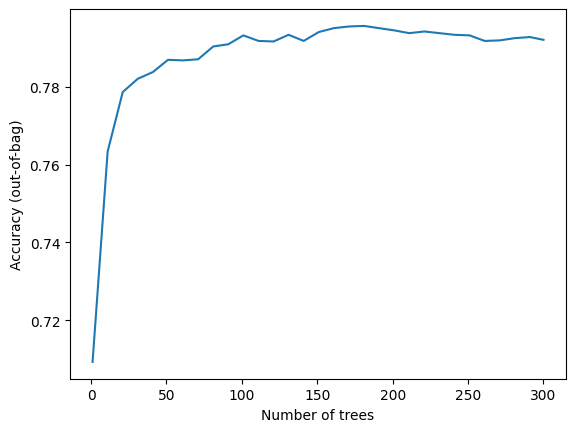

2/2 [==============================] - 0s 64ms/step - loss: 0.0000e+00 - accuracy: 0.7996
loss: 0.0000
accuracy: 0.7996


In [93]:
# Evaluate the model on the Out of bag (OOB) data and the validation dataset
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

inspector = model.make_inspector()
inspector.evaluation()

evaluation = model.evaluate(x=valid_ds, return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

In [94]:
# Variable importances
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

# Example: Display important features for the Variable Importance "NUM_AS_ROOT"
importance_scores = inspector.variable_importances()["NUM_AS_ROOT"]
print("Variable Importance for NUM_AS_ROOT:", importance_scores)

Available variable importances:
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
Variable Importance for NUM_AS_ROOT: [("CryoSleep" (1; #2), 110.0), ("Spa" (1; #10), 68.0), ("RoomService" (1; #7), 53.0), ("VRDeck" (1; #12), 33.0), ("ShoppingMall" (1; #8), 16.0), ("FoodCourt" (1; #5), 13.0), ("Deck" (4; #3), 6.0), ("HomePlanet" (4; #6), 1.0)]


In [95]:
test_df = pd.read_csv('test.csv')
submission_id = test_df['PassengerId']

In [96]:
# Replace NaN values with zeros for certain columns
test_df[columns_to_fill_with_zeros] = test_df[columns_to_fill_with_zeros].fillna(value=0)

# Split the 'Cabin' column into 'Deck', 'Cabin_num', and 'Side'
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
try:
    test_df = test_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

# Convert boolean columns to integers
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

In [97]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

In [98]:
predictions = model.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)

5/5 [==============================] - 1s 76ms/step


In [99]:
output = pd.DataFrame({'PassengerId': submission_id, 'Transported': n_predictions.squeeze()})
output.to_csv('submission.csv', index=False)